# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import ranksums, ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.power import TTestIndPower
import statsmodels.stats.multicomp as mc

from sklearn.preprocessing import StandardScaler

import os
import json

C:\Users\smran\AppData\Roaming\Python\Python39\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
with open('data/paths.json','r') as f:
    paths = json.load(f)

data_path = paths["data_path"]

In [3]:
with open('date_lipids.txt','r') as f:
    lipid_names = f.read().splitlines()
print(lipid_names)

['CER(16:0)+H', 'CER(22:0)+H', 'CER(22:1)+H', 'CER(24:0)+H', 'DAG(16:0_20:3)+NH4', 'DAG(16:0_22:5)+NH4', 'DAG(16:1_18:1)+NH4', 'DAG(18:1_20:3)+NH4', 'DAG(18:1_22:4)+NH4', 'DCER(16:0)+H', 'DCER(18:1)+H', 'DCER(20:0)+H', 'DCER(20:1)+H', 'HCER(18:0)+H', 'HCER(24:1)+H', 'LPC(16:0)+AcO', 'LPC(16:1)+AcO', 'LPC(18:0)+AcO', 'LPC(18:1)+AcO', 'LPC(20:2)+AcO', 'LPC(20:3)+AcO', 'LPC(22:6)+AcO', 'LPE(16:0)-H', 'LPE(18:1)-H', 'LPI(20:3)-H', 'LPS(18:0)-H', 'MAG(18:0)+NH4', 'MAG(20:1)+NH4', 'PC(16:0_16:1)+AcO', 'PC(16:0_18:1)+AcO', 'PC(16:0_18:2)+AcO', 'PC(16:0_18:3)+AcO', 'PC(16:0_20:3)+AcO', 'PC(16:0_20:4)+AcO', 'PC(16:0_22:4)+AcO', 'PC(16:0_22:5)+AcO', 'PC(16:1_18:2)+AcO', 'PC(18:0_16:1)+AcO', 'PC(18:0_18:1)+AcO', 'PC(18:0_18:2)+AcO', 'PC(18:0_20:3)+AcO', 'PC(18:0_20:4)+AcO', 'PC(18:2_18:2)+AcO', 'PE(16:0_16:0)-H', 'PE(16:0_20:4)-H', 'PE(16:0_22:6)-H', 'PE(18:0_16:1)-H', 'PE(18:0_18:1)-H', 'PE(18:0_20:2)-H', 'PE(18:1_18:1)-H', 'PE(18:1_20:4)-H', 'PE(18:1_22:5)-H', 'PE(18:2_16:1)-H', 'PE(18:2_18:2)-

In [4]:
sns.set(style = 'whitegrid')

# Load data

In [5]:
data_tmp = pd.read_csv(os.path.join(data_path,'clean_data.csv'))
data_tmp.head()

,Sample Number,Sample Submission Date,Sample Name,Sex,Tissue weight (mg),Treatment,Tissue Type,PND,Litter,Individual Lipid Species,Lipid Class,MRM Transition of each lipid species\r\n(Parent ion / Fragment ion),Lipid Species used as Internal Standard,Retention Time (min),Peak Area of Lipid Species,Peak Area of Internal Standard,Normalized Peak Area (Peak Area of Lipid Species / (Peak Area of Internal Standard * Tissue Weight))
0,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(14:0)+H,SM,675.5 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.737513,4.116176e+06,4.165659e+07,0.000842
1,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(16:0)+H,SM,703.6 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.662914,2.433723e+07,4.165659e+07,0.006390
2,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:0)+H,SM,731.6 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.580159,1.432478e+08,4.165659e+07,0.036989
3,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:1)+H,SM,729.6 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.572303,1.268323e+08,4.165659e+07,0.046320
4,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(20:0)+H,SM,759.6 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.486523,5.419340e+06,4.165659e+07,0.001167


In [6]:
data = data_tmp.loc[~data_tmp['Individual Lipid Species'].isin(lipid_names)].copy(deep=True)
data.head()

,Sample Number,Sample Submission Date,Sample Name,Sex,Tissue weight (mg),Treatment,Tissue Type,PND,Litter,Individual Lipid Species,Lipid Class,MRM Transition of each lipid species\r\n(Parent ion / Fragment ion),Lipid Species used as Internal Standard,Retention Time (min),Peak Area of Lipid Species,Peak Area of Internal Standard,Normalized Peak Area (Peak Area of Lipid Species / (Peak Area of Internal Standard * Tissue Weight))
0,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(14:0)+H,SM,675.5 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.737513,4.116176e+06,4.165659e+07,0.000842
1,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(16:0)+H,SM,703.6 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.662914,2.433723e+07,4.165659e+07,0.006390
2,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:0)+H,SM,731.6 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.580159,1.432478e+08,4.165659e+07,0.036989
3,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:1)+H,SM,729.6 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.572303,1.268323e+08,4.165659e+07,0.046320
6,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(22:1)+H,SM,785.7 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.411746,4.493430e+06,4.165659e+07,0.001478


In [7]:
len(data['Lipid Class'].unique())

21

In [8]:
data['Sex'].value_counts()
data['Sample Submission Date'].value_counts()

09/2021    23815
11/2022    11036
Name: Sample Submission Date, dtype: int64

In [9]:
std_scaler = StandardScaler()
data['log_area'] = np.log10(data['Normalized Peak Area (Peak Area of Lipid Species / (Peak Area of Internal Standard * Tissue Weight))'])
data['log_scaled_area'] = std_scaler.fit_transform(data[['log_area']])
data.head()

,Sample Number,Sample Submission Date,Sample Name,Sex,Tissue weight (mg),Treatment,Tissue Type,PND,Litter,Individual Lipid Species,Lipid Class,MRM Transition of each lipid species\r\n(Parent ion / Fragment ion),Lipid Species used as Internal Standard,Retention Time (min),Peak Area of Lipid Species,Peak Area of Internal Standard,Normalized Peak Area (Peak Area of Lipid Species / (Peak Area of Internal Standard * Tissue Weight)),log_area,log_scaled_area
0,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(14:0)+H,SM,675.5 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.737513,4.116176e+06,4.165659e+07,0.000842,-3.074916,-0.260438
1,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(16:0)+H,SM,703.6 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.662914,2.433723e+07,4.165659e+07,0.006390,-2.194512,0.402772
2,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:0)+H,SM,731.6 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.580159,1.432478e+08,4.165659e+07,0.036989,-1.431924,0.977231
3,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:1)+H,SM,729.6 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.572303,1.268323e+08,4.165659e+07,0.046320,-1.334233,1.050822
6,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(22:1)+H,SM,785.7 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.411746,4.493430e+06,4.165659e+07,0.001478,-2.830262,-0.076139


# Manipulate data

Extract log value of the target variable

In [10]:
columns_to_log_transform = ['Normalized Peak Area (Peak Area of Lipid Species / (Peak Area of Internal Standard * Tissue Weight))']

for c in columns_to_log_transform:
    data['log'+c[0].capitalize()+c[1:]] = data[c].apply(lambda x: np.log10(x))

data.rename(columns= {'Tissue Type':'TissueType','logNormalized Peak Area (Peak Area of Lipid Species / (Peak Area of Internal Standard * Tissue Weight))':'logNormalizedArea'}, inplace=True)

Add a column to identify the date

In [11]:
def classify_date(input_date):
    if input_date == '09/2021':
        return 1
    else:
        return 2

data['dateId'] = data['Sample Submission Date'].apply(lambda x: classify_date(x))

Drop NaN

Drop normalization factors

In [12]:
# We don't have the column of the normalizationFactor because the NormalizationSpecies are not in the list

# data_normalized = data[data['isNormalizationFactor'] == False]
# print(f'Number of points after dropping the normalization factors: {data_normalized.shape[0]}')

In [13]:
df_sub = data[(data['TissueType'] == 'cortex') & (data['PND'] == 30)].copy()
df_sub['class'] = [0 if x == 'control' else 1 for x in df_sub['Treatment']]

df_pivot = df_sub.pivot_table(index='Individual Lipid Species', columns='Sample Number',values='logNormalizedArea',dropna=True).T


class_values = df_sub.groupby('Sample Number').mean()['class']

print(df_pivot.columns)


Index(['CE(14:0)+H', 'CE(16:1)+H', 'CE(18:0)+H', 'CE(18:1)+H', 'CE(18:2)+H',
       'CE(18:3)+H', 'CE(20:0)+H', 'CE(20:2)+H', 'CE(20:3)+H', 'CE(20:4)+H',
       ...
       'TAG(58:8_FA18:1)+NH4', 'TAG(58:8_FA20:4)+NH4', 'TAG(58:8_FA22:5)+NH4',
       'TAG(58:8_FA22:6)+NH4', 'TAG(58:9_FA20:4)+NH4', 'TAG(58:9_FA22:6)+NH4',
       'TAG(60:10_FA22:5)+NH4', 'TAG(60:10_FA22:6)+NH4',
       'TAG(60:11_FA22:6)+NH4', 'TAG(60:12_FA22:6)+NH4'],
      dtype='object', name='Individual Lipid Species', length=594)


# Figures

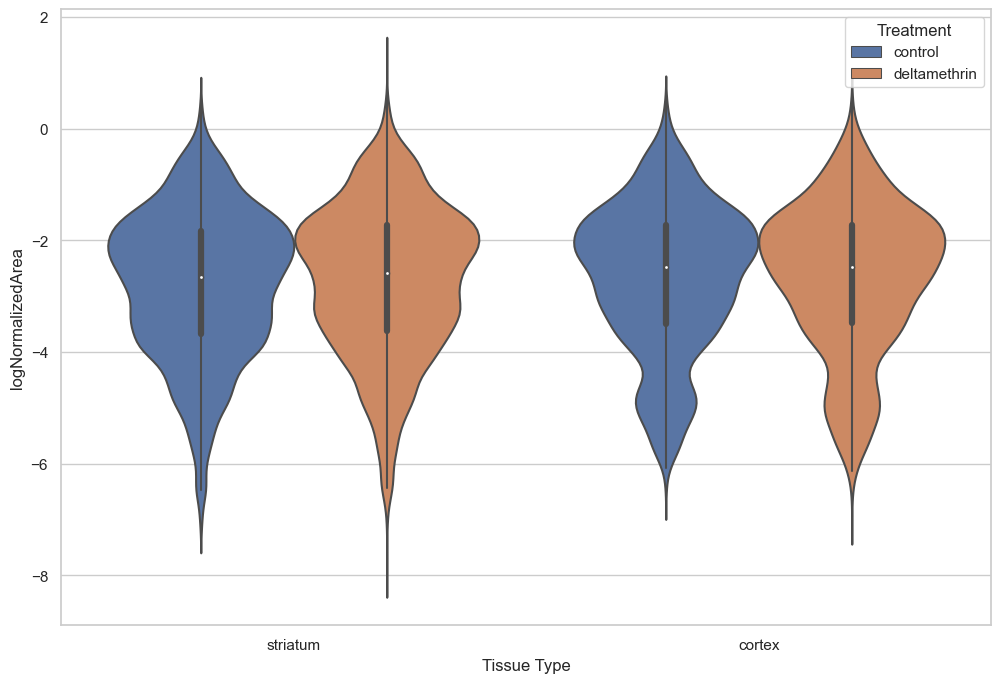

In [14]:
fig100 = plt.figure(figsize=(12,8))
ax = sns.violinplot(data=data, x='TissueType', hue='Treatment', y='logNormalizedArea')
ax.set_xlabel('Tissue Type')

fig100.savefig(os.path.join(data_path,"violinplot-tissue.svg"), format='svg', facecolor='w')

plt.show()

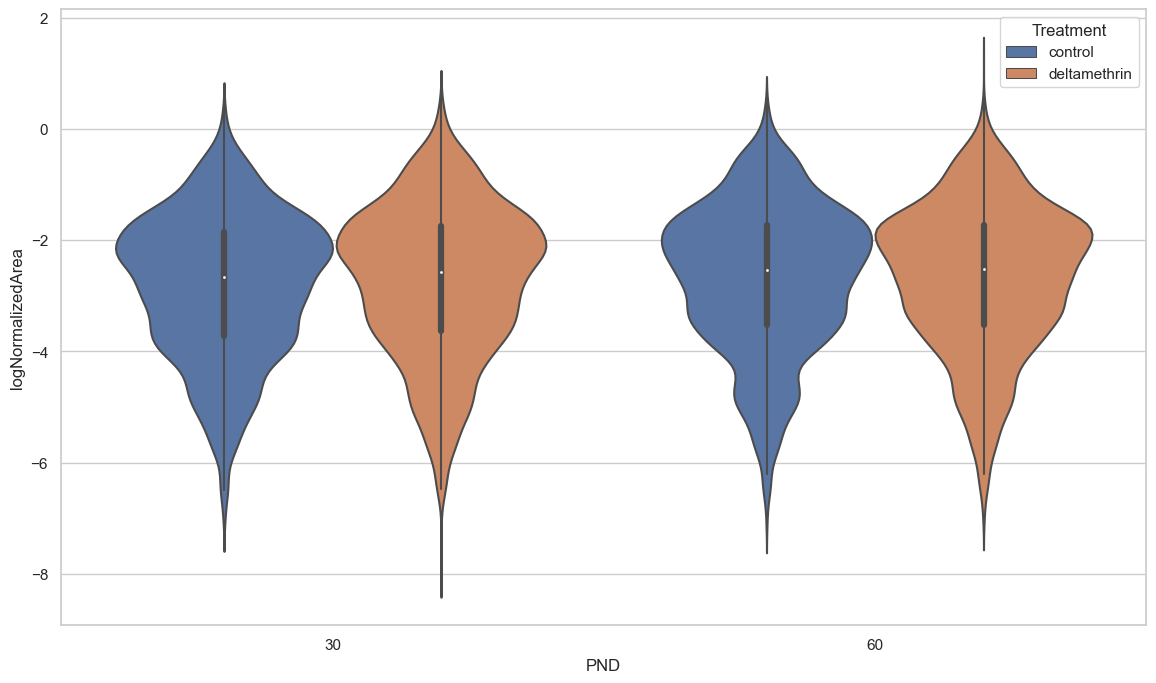

In [15]:
fig = plt.figure(figsize=(14,8))
ax = sns.violinplot(data=data, x='PND', hue='Treatment', y='logNormalizedArea')
ax.set_xlabel('PND')
                    
fig.savefig(os.path.join(data_path,"violinplot-pnd.svg"), format='svg', facecolor='w')

plt.show()

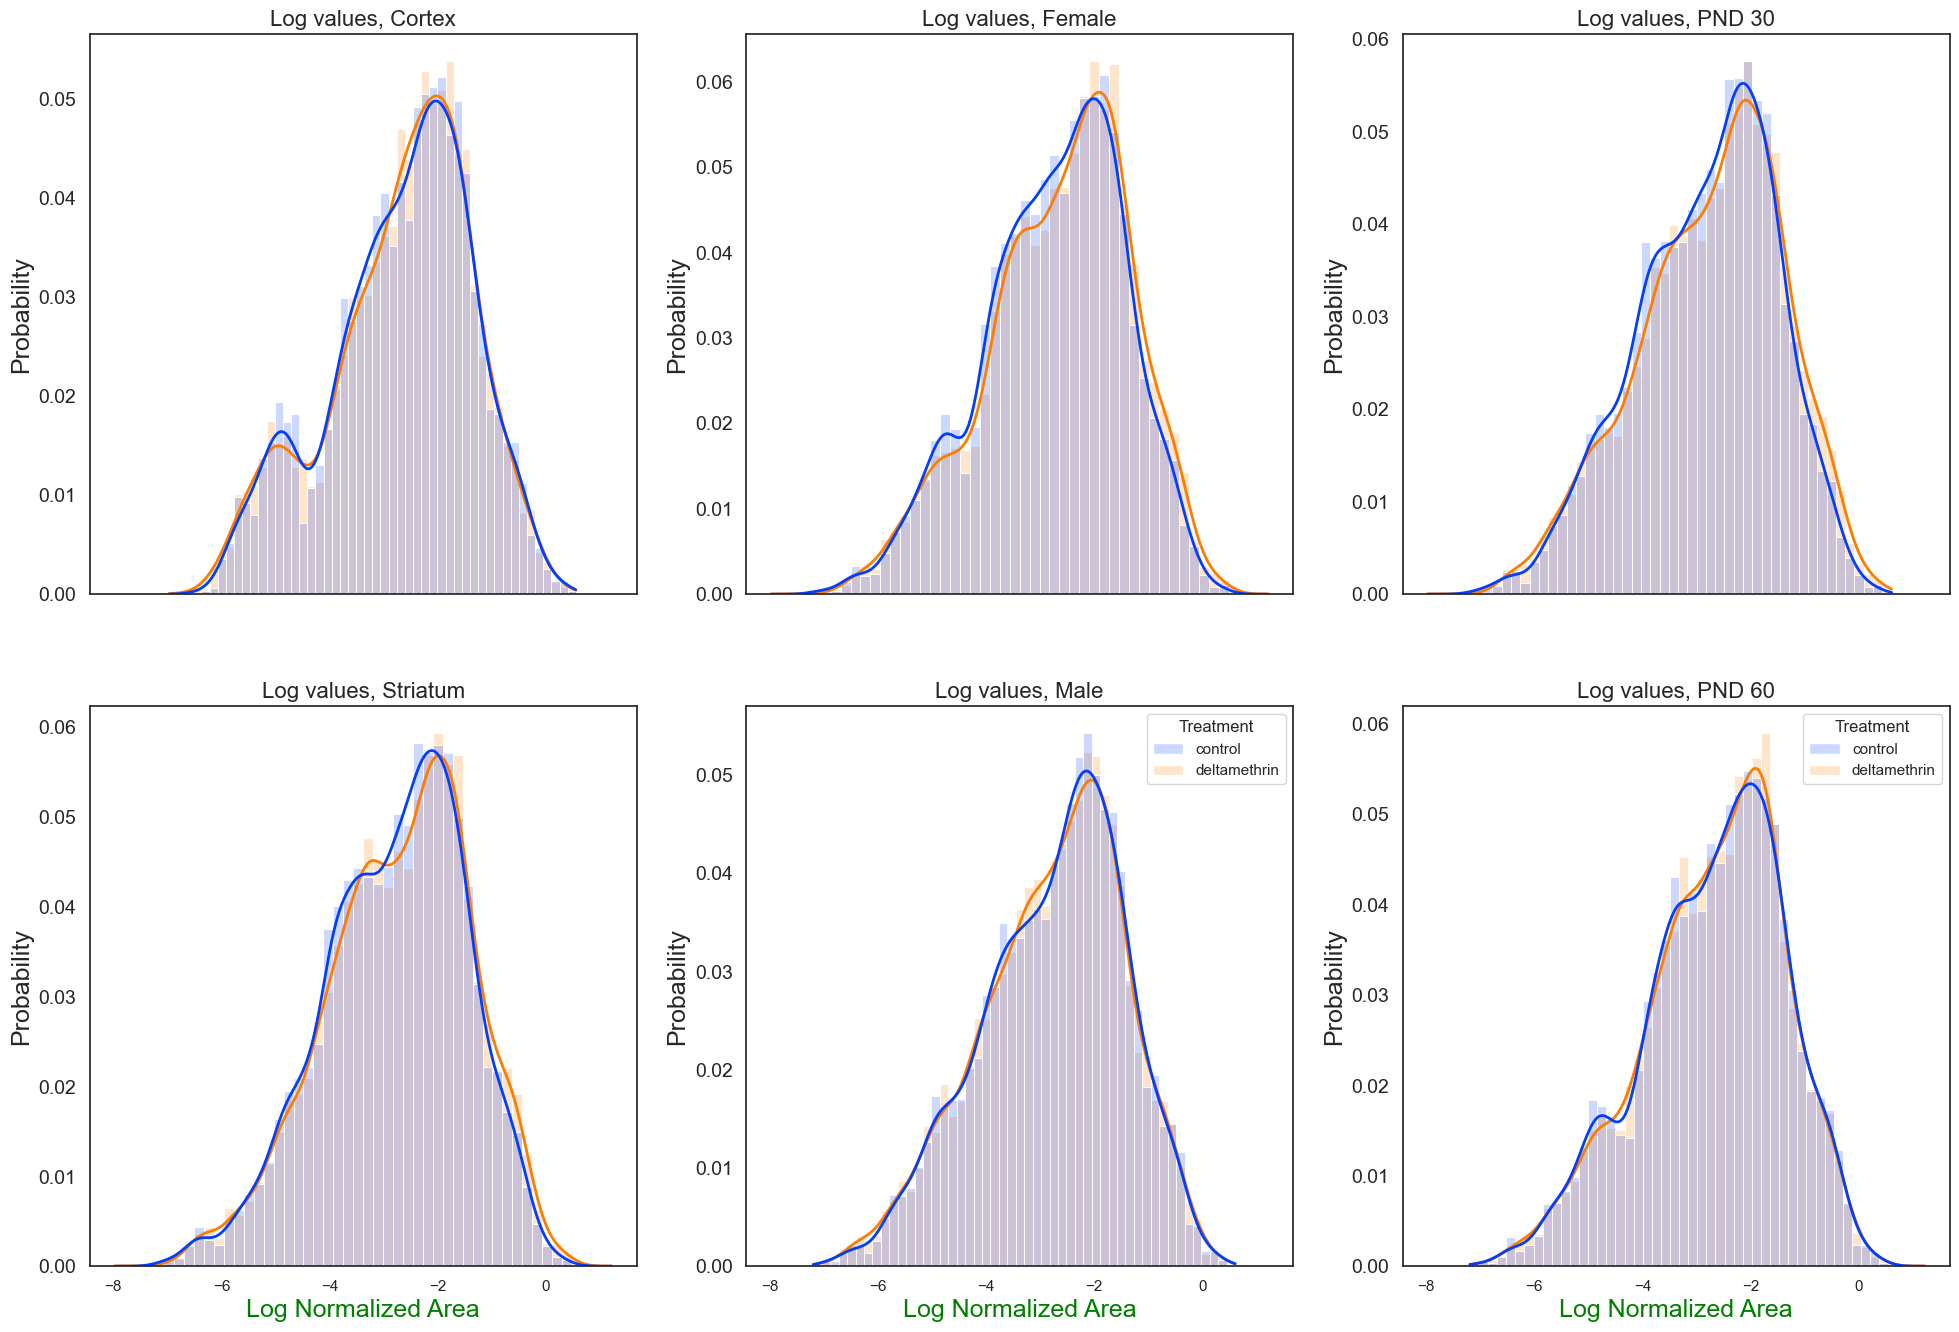

In [16]:
sns.set_style('white')

fig, ax = plt.subplots(2, 3, sharex=True, figsize=(24,16), )

opt = {'bins': 50, 'alpha': 0.2, 'palette': 'bright',
        'stat': 'probability', 'kde': True,
        'line_kws': {'lw': 2}, 'common_norm': False}

sns.histplot(data=data[data['TissueType'] == 'cortex'], x='logNormalizedArea', hue='Treatment', ax=ax[0,0], legend=False, **opt)
ax[0,0].set_title('Log values, Cortex', fontsize=16)
ax[0,0].set_ylabel('Probability', fontsize=18)
ax[0,0].tick_params(axis='y', labelsize=14)
sns.histplot(data=data[data['TissueType'] == 'striatum'], x='logNormalizedArea', hue='Treatment', ax=ax[1,0], legend=False, **opt)
ax[1,0].set_title('Log values, Striatum', fontsize=16)
ax[1,0].set_xlabel('Log Normalized Area', fontsize=18, color='green')
ax[1,0].set_ylabel('Probability', fontsize=18)
ax[1,0].tick_params(axis='y', labelsize=14)

sns.histplot(data=data[data['Sex'] == 'F'], x='logNormalizedArea', hue='Treatment', ax=ax[0,1], legend=False, **opt)
ax[0,1].set_title('Log values, Female', fontsize=16)
ax[0,1].set_ylabel('Probability', fontsize=18)
ax[0,1].tick_params(axis='y', labelsize=14)
sns.histplot(data=data[data['Sex'] == 'M'], x='logNormalizedArea', hue='Treatment', ax=ax[1,1], legend=True, **opt)
ax[1,1].set_title('Log values, Male', fontsize=16)
ax[1,1].set_xlabel('Log Normalized Area', fontsize=18, color='green')
ax[1,1].set_ylabel('Probability', fontsize=18)
ax[1,1].tick_params(axis='y', labelsize=14)

sns.histplot(data=data[data['PND'] == 30], x='logNormalizedArea', hue='Treatment', ax=ax[0,2], legend=False, **opt)
ax[0,2].set_title('Log values, PND 30', fontsize=16)
ax[0,2].set_ylabel('Probability', fontsize=18)
ax[0,2].tick_params(axis='y', labelsize=14)
sns.histplot(data=data[data['PND'] == 60], x='logNormalizedArea', hue='Treatment', ax=ax[1,2], legend=True, **opt)
ax[1,2].set_title('Log values, PND 60', fontsize=16)
ax[1,2].set_xlabel('Log Normalized Area', fontsize=18, color='green')
ax[1,2].set_ylabel('Probability', fontsize=18)
ax[1,2].tick_params(axis='y', labelsize=14)

fig.savefig(os.path.join(data_path,"distribution-3cases.png"), format='png', facecolor='w', dpi=600)

plt.show()

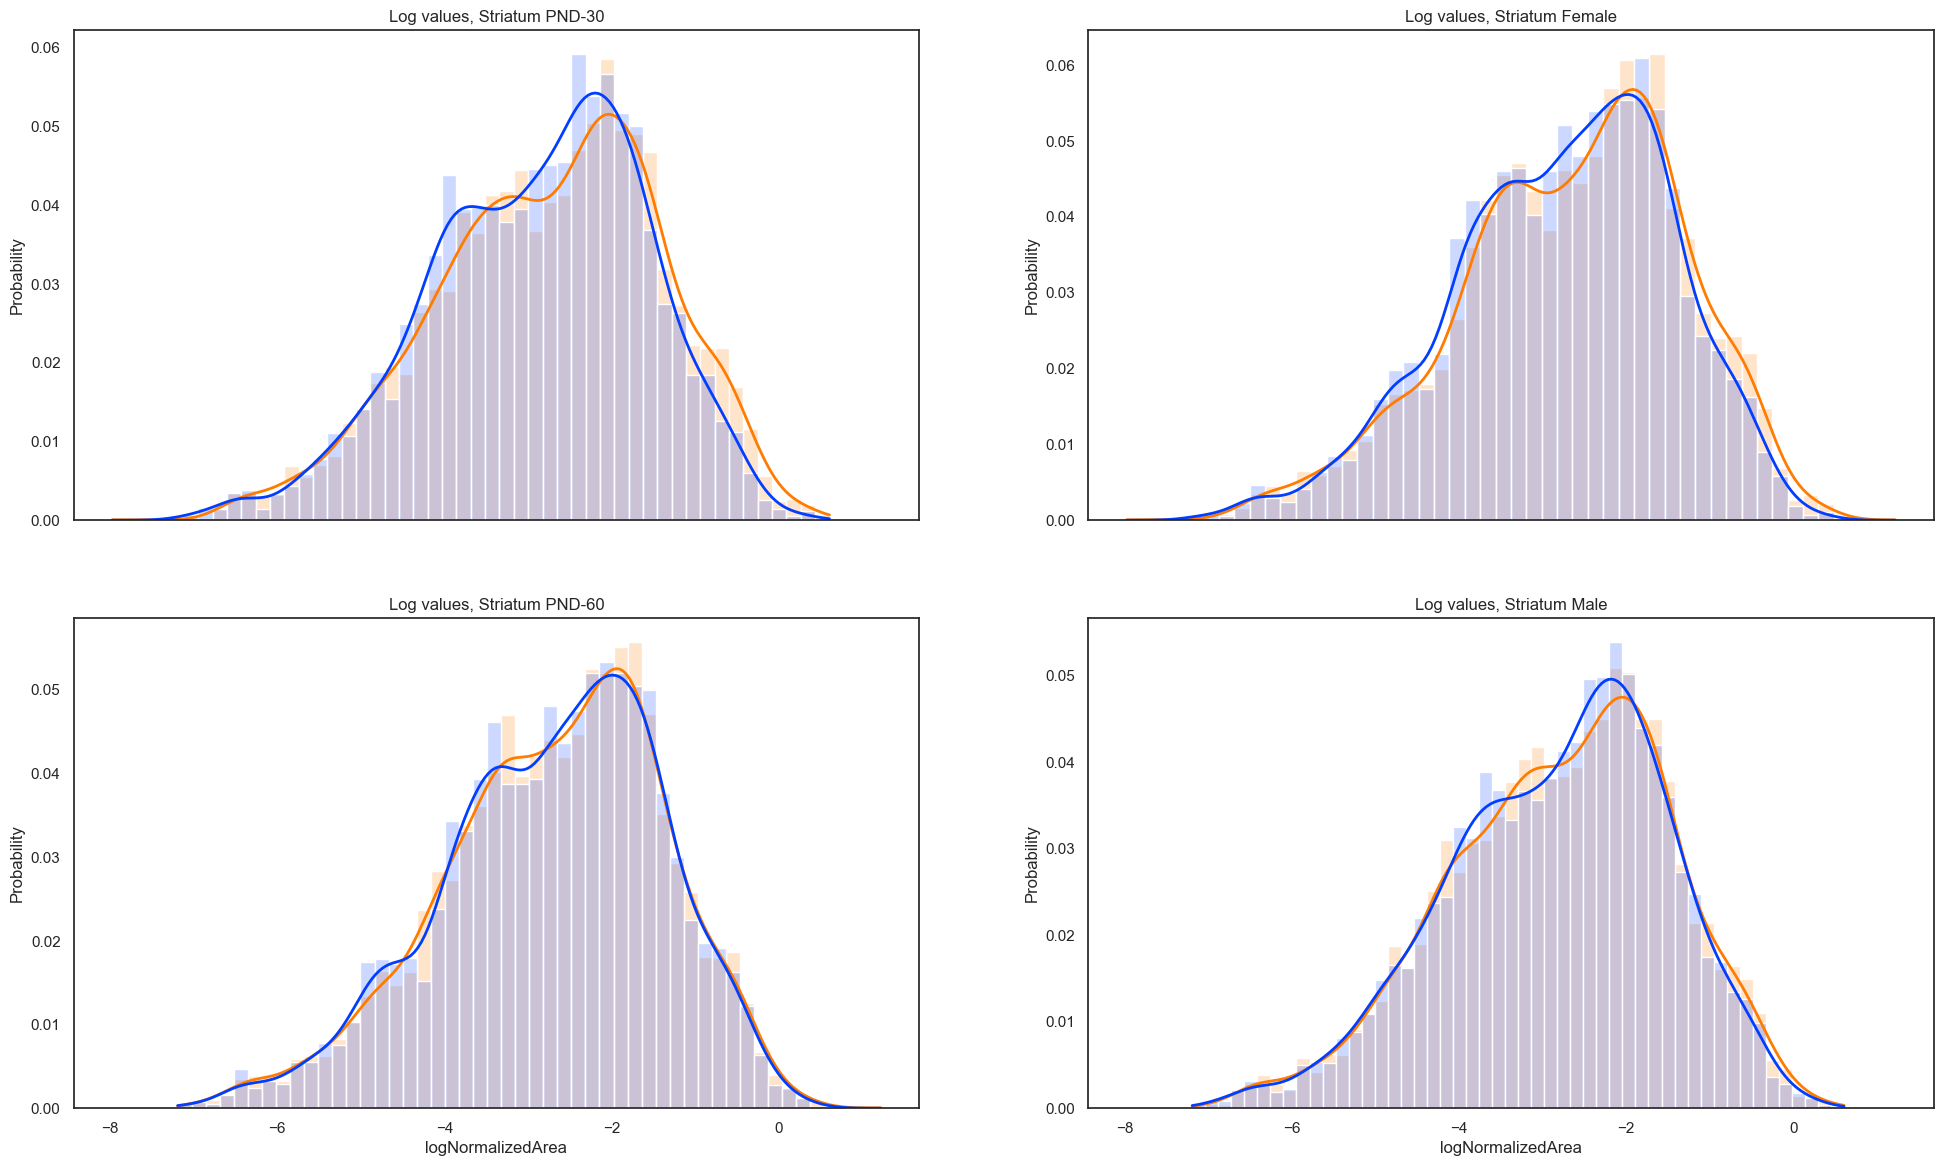

In [17]:
sns.set_style('white')

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(24,14))

opt = {'bins': 50, 'alpha': 0.2, 'palette': 'bright',
        'stat': 'probability', 'kde': True,
        'line_kws': {'lw': 2}, 'common_norm': False}

sns.histplot(data=data[(data['TissueType'] == 'striatum') & (data['PND'] == 30)], x='logNormalizedArea', hue='Treatment', ax=ax[0,0], legend=False, **opt)
ax[0,0].set_title('Log values, Striatum PND-30')
sns.histplot(data=data[(data['TissueType'] == 'striatum') & (data['PND'] == 60)], x='logNormalizedArea', hue='Treatment', ax=ax[1,0], legend=False, **opt)
ax[1,0].set_title('Log values, Striatum PND-60')

sns.histplot(data=data[(data['TissueType'] == 'striatum') & (data['Sex'] == 'F')], x='logNormalizedArea', hue='Treatment', ax=ax[0,1], legend=False, **opt)
ax[0,1].set_title('Log values, Striatum Female')
sns.histplot(data=data[(data['TissueType'] == 'striatum') & (data['Sex'] == 'M')], x='logNormalizedArea', hue='Treatment', ax=ax[1,1], legend=False, **opt)
ax[1,1].set_title('Log values, Striatum Male')

fig.savefig(os.path.join(data_path,"distribution-Striatum-2cases.svg"), format='svg', facecolor='w')

plt.show()

# Statistics

## Wilcoxon test applied on the data with no normalization

#### Data divided by tissue

In [18]:
tissue = ['striatum','cortex']
sex = ['F', 'M']
pnd = [30,60]
var_name = 'logNormalizedArea'


for t in tissue:
    a = data[(data['Treatment'] == 'control') & (data['TissueType']==t)][var_name]
    b = data[(data['Treatment'] == 'deltamethrin') & (data['TissueType']==t)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'Tissue: {t}. P-value: {ranksums(a,b).pvalue:.2e}')

Tissue: striatum. P-value: 2.51e-05
Tissue: cortex. P-value: 7.35e-01


#### Data divided by gender

In [19]:
for g in sex:
    a = data[(data['Treatment'] == 'control') & (data['Sex']==g)][var_name]
    b = data[(data['Treatment'] == 'deltamethrin') & (data['Sex']==g)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'Gender: {g}. P-value: {ranksums(a,b).pvalue:.2e}')

Gender: F. P-value: 8.10e-09
Gender: M. P-value: 5.16e-01


#### Data divided by PND

In [20]:
for p in pnd:
    a = data[(data['Treatment'] == 'control') & (data['PND']==p)][var_name]
    b = data[(data['Treatment'] == 'deltamethrin') & (data['PND']==p)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'PND: {p}. P-value: {ranksums(a,b).pvalue:.2e}')

PND: 30. P-value: 2.83e-06
PND: 60. P-value: 7.12e-01


## T-test applied on the data with log normalization

#### Data divided by tissue

In [21]:
var_name = 'logNormalizedArea'

for t in tissue:
    a = data[(data['Treatment'] == 'control') & (data['TissueType']==t)][var_name]
    b = data[(data['Treatment'] == 'deltamethrin') & (data['TissueType']==t)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'Tissue: {t}. P-value: {ttest_ind(a,b).pvalue:.2e}')

Tissue: striatum. P-value: 5.60e-05
Tissue: cortex. P-value: 9.94e-01


#### Data divided by gender

In [22]:
for g in sex:
    a = data[(data['Treatment'] == 'control') & (data['Sex']==g)][var_name]
    b = data[(data['Treatment'] == 'deltamethrin') & (data['Sex']==g)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'Gender: {g}. P-value: {ttest_ind(a,b).pvalue:.2e}')

Gender: F. P-value: 1.09e-07
Gender: M. P-value: 4.71e-01


#### Data divided by PND

In [23]:
for p in pnd:
    a = data[(data['Treatment'] == 'control') & (data['PND']==p)][var_name]
    b = data[(data['Treatment'] == 'deltamethrin') & (data['PND']==p)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'PND: {p}. P-value: {ranksums(a,b).pvalue:.2e}')

PND: 30. P-value: 2.83e-06
PND: 60. P-value: 7.12e-01


## Three-way ANOVA on log normalized data

#### Quelli singoli sono mediati su tutto il resto. Mentre l'effetto del secondo oridne dice che è vero che partono da livelli differenti diversi striato e corteccia, ma l'effetto del trattamento ha effetto anche se loro sono già diversi

In [24]:
model = ols('logNormalizedArea ~ C(Sex) + C(Treatment) + C(TissueType) + C(dateId) + C(Sex):C(Treatment) + C(TissueType):C(Treatment) + C(dateId):C(Treatment)', data=data).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Sex),40.653394,1.0,23.158369,1.498164e-06
C(Treatment),18.878511,1.0,10.754219,1.041438e-03
C(TissueType),1.117174,1.0,0.636402,4.250220e-01
C(dateId),102.277614,1.0,58.262853,2.351765e-14
C(Sex):C(Treatment),31.061258,1.0,17.694170,2.600684e-05
C(TissueType):C(Treatment),8.096690,1.0,4.612312,3.175008e-02
C(dateId):C(Treatment),0.026429,1.0,0.015055,9.023453e-01
Residual,61165.197413,34843.0,NaN,NaN


In [25]:
model = ols('logNormalizedArea ~ C(Sex) + C(PND) + C(Treatment) + C(TissueType) + C(PND):C(Treatment) + C(Sex):C(Treatment) + C(TissueType):C(Treatment)', data=data).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Sex),41.337272,1.0,23.540975,1.228094e-06
C(PND),70.694778,1.0,40.259648,2.250821e-10
C(Treatment),18.322857,1.0,10.434600,1.237910e-03
C(TissueType),46.030884,1.0,26.213919,3.072354e-07
C(PND):C(Treatment),13.505444,1.0,7.691154,5.552164e-03
C(Sex):C(Treatment),31.148333,1.0,17.738522,2.540780e-05
C(TissueType):C(Treatment),9.603163,1.0,5.468861,1.936386e-02
Residual,61183.301234,34843.0,NaN,NaN


### Anova only striatum

In [26]:
data_striatum = data[data['TissueType'] == 'striatum'].copy(deep=True)

In [27]:
model = ols('logNormalizedArea ~ C(Sex) + C(Treatment)  + C(Sex):C(Treatment)', data=data_striatum).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Sex),57.498145,1.0,32.672473,1.104180e-08
C(Treatment),28.490435,1.0,16.189270,5.750084e-05
C(Sex):C(Treatment),8.572723,1.0,4.871323,2.731638e-02
Residual,40539.547634,23036.0,NaN,NaN


In [28]:
model = ols('logNormalizedArea ~ C(Sex) + C(PND) + C(Treatment)+ C(PND):C(Treatment) + C(Sex):C(Treatment)', data=data_striatum).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Sex),57.374328,1.0,32.662398,1.109912e-08
C(PND),61.294424,1.0,34.894053,3.530332e-09
C(Treatment),28.032446,1.0,15.958477,6.494834e-05
C(PND):C(Treatment),17.038717,1.0,9.699902,1.845039e-03
C(Sex):C(Treatment),8.707421,1.0,4.957012,2.599470e-02
Residual,40461.214493,23034.0,NaN,NaN


# Single lipids statistics

## Define lipids list

In [29]:
lipids_list = data['Individual Lipid Species'].unique()
print(lipids_list.shape[0])

739


## Test lipid

In [30]:
data_lipid = data[data['Individual Lipid Species'] == lipids_list[0]]

from scipy.stats import ttest_ind
multcomp = mc.MultiComparison(data_lipid['logNormalizedArea'], groups=data_lipid['Treatment'])
res = multcomp.allpairtest(ttest_ind)[1][2][0]
print(res)
res = multcomp.allpairtest(ttest_ind)[0]
print(res)

0.03291755956471103
Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.05, alphacBonf=0.050
 group1    group2     stat   pval  pval_corr reject
---------------------------------------------------
control deltamethrin 2.1762 0.0329    0.0329   True
---------------------------------------------------


## Analysis control vs treatment

In [31]:
import itertools
factor = 'Treatment'
results_all = []
for l in lipids_list:
    data_lipid = data[data['Individual Lipid Species'] == l]
    if data_lipid[factor].unique().size > 1: # Some lipids are not found in both classes
        for c in itertools.combinations(data_lipid[factor].unique(),2):
            a = data_lipid[data_lipid[factor] == c[0]]['logNormalizedArea'].values
            b = data_lipid[data_lipid[factor] == c[1]]['logNormalizedArea'].values
            pvalue = ttest_ind(a,b)[1]
            fc = np.mean(a)/np.mean(b)
            cd = np.abs((np.mean(a) - np.mean(b)))
            cd /= np.sqrt(
                ((a.size - 1)*np.var(a) + (b.size - 1)*np.var(b)) / (a.size + b.size - 2)
            )
            n_samples = a.size
            sp = TTestIndPower().power(effect_size=cd, nobs1=n_samples, alpha=0.05)
            results_all.append([l, fc, pvalue, c[0], c[1], cd, n_samples, sp])

colnames = ['lipid', 'fc', 'p', factor+'1', factor+'2', 'effectSize', 'sampleSize', 'statisticalPower']
results_all = pd.DataFrame(data=results_all, columns= colnames)
results_all.head()

C:\Users\smran\AppData\Local\Temp\ipykernel_18528\788473265.py:10: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  pvalue = ttest_ind(a,b)[1]
C:\Users\smran\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:1250: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\smran\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:1250: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\smran\AppData\Local\Temp\ipykernel_18528\788473265.py:14: RuntimeWarning: invalid value encountered in double_scalars
  ((a.size - 1)*np.var(a) + (b.size - 1)*np.var(b)) / (a.size + b.size - 2)


,lipid,fc,p,Treatment1,Treatment2,effectSize,sampleSize,statisticalPower
0,SM(14:0)+H,0.979101,0.032918,control,deltamethrin,0.520210,36,0.585817
1,SM(16:0)+H,0.981280,0.162395,control,deltamethrin,0.337520,36,0.292354
2,SM(18:0)+H,0.973330,0.367727,control,deltamethrin,0.216720,36,0.148227
3,SM(18:1)+H,0.973903,0.152439,control,deltamethrin,0.345832,36,0.304364
4,SM(22:1)+H,0.828580,0.003270,control,deltamethrin,0.798749,29,0.848268


### Statistical power with average effectSize

In [32]:
es_mean = np.median(results_all['effectSize'][results_all['p']<0.05])
# es_mean = 0.8
print(es_mean)
n_mice = 24
statisticalPower = TTestIndPower().power(effect_size=es_mean, nobs1=n_mice, alpha=0.05)
print(statisticalPower)

0.7133361767983386
0.6769803530305349


### Given an effect size, and a statistical power, determine n_mice

In [33]:
es_mean = 0.7
alpha = 0.05
statisticalPower = 0.8
n_mice_ideal = TTestIndPower().solve_power(effect_size=es_mean, alpha=alpha, power=statisticalPower)
print(n_mice_ideal)

33.02456951586259


## Plots

In [34]:
def adjustlabels(fig, labels, max_iter=1000, eps=0.01, delta=0.1, 
                 clip_to_axes=True, pad=0.1):
    N = len(labels)
    widths = np.zeros(N)
    heights = np.zeros(N)
    centers = np.zeros((N, 2))
    for i,l in enumerate(labels):
        bb = l.get_window_extent(renderer=fig.canvas.get_renderer())
        bb = bb.transformed(plt.gca().transData.inverted())
        widths[i] = bb.width
        heights[i] = bb.height
        centers[i] = (bb.min + bb.max)/2
        
    ylim = plt.gca().get_ylim()
    xlim = plt.gca().get_xlim()    

    def clip():
        for i in range(N):
            centers[i,0] = max(centers[i,0], xlim[0] + widths[i]/2 + pad)
            centers[i,0] = min(centers[i,0], xlim[1] - widths[i]/2 - pad)
            centers[i,1] = max(centers[i,1], ylim[0] + heights[i]/2 + pad)
            centers[i,1] = min(centers[i,1], ylim[1] - heights[i]/2 - pad)
            labels[i].set_position(centers[i])
    clip()

    for i in range(max_iter):
        stop = True
        for a in range(N):
            for b in range(N):
                if ((a!=b) and
                    (np.abs(centers[a,0]-centers[b,0]) < (widths[a]+widths[b])/2 + delta) and
                    (np.abs(centers[a,1]-centers[b,1]) < (heights[a]+heights[b])/2 +  delta)):
                    
                    d = centers[a] - centers[b]
                    centers[a] += d * eps
                    centers[b] -= d * eps
                    labels[a].set_position(centers[a])
                    labels[b].set_position(centers[b])
                    if clip_to_axes:
                        clip()
                    stop = False
        if stop:
            break 

In [35]:
def plot_volcano(results_all, fc_threshold=0.3, pvalue_threshold=1.5):
    
    col = np.where(np.log2(results_all['fc']) < -fc_threshold,'r',np.where(np.log2(results_all['fc']) > fc_threshold,'g','k'))

    fig = plt.figure(figsize=(14,12))
    plt.scatter(np.log2(results_all['fc']), -np.log10(results_all['p']), c=col)
    shownlabels = []
    l_ha = ['right','left']

    for i in range(results_all.shape[0]): 

        x = np.log2(results_all.iloc[i]['fc'])
        y = -np.log10(results_all.iloc[i]['p'])
        aa = np.random.rand()*3 - 1.5 + 0.5 * np.sign(x)
        ii = np.sign(aa) * 0.5 + 0.5
        if (np.abs(x) > fc_threshold) and (y > pvalue_threshold):
            l = plt.text(x+0.1*aa, y, 
                         results_all.iloc[i]['lipid'],ha=l_ha[int(ii)], va='center', color='k', 
                         fontsize=10, zorder=10,bbox=dict(facecolor='w', edgecolor='#777777', boxstyle='round', linewidth=.5, pad=.2))
            shownlabels.append(l)

    #adjustlabels(fig, shownlabels)

    plt.xlabel('log FC',)
    plt.ylabel('-log10 (Pvalue)')
    plt.rc('axes', labelsize=18) 

    plt.show()

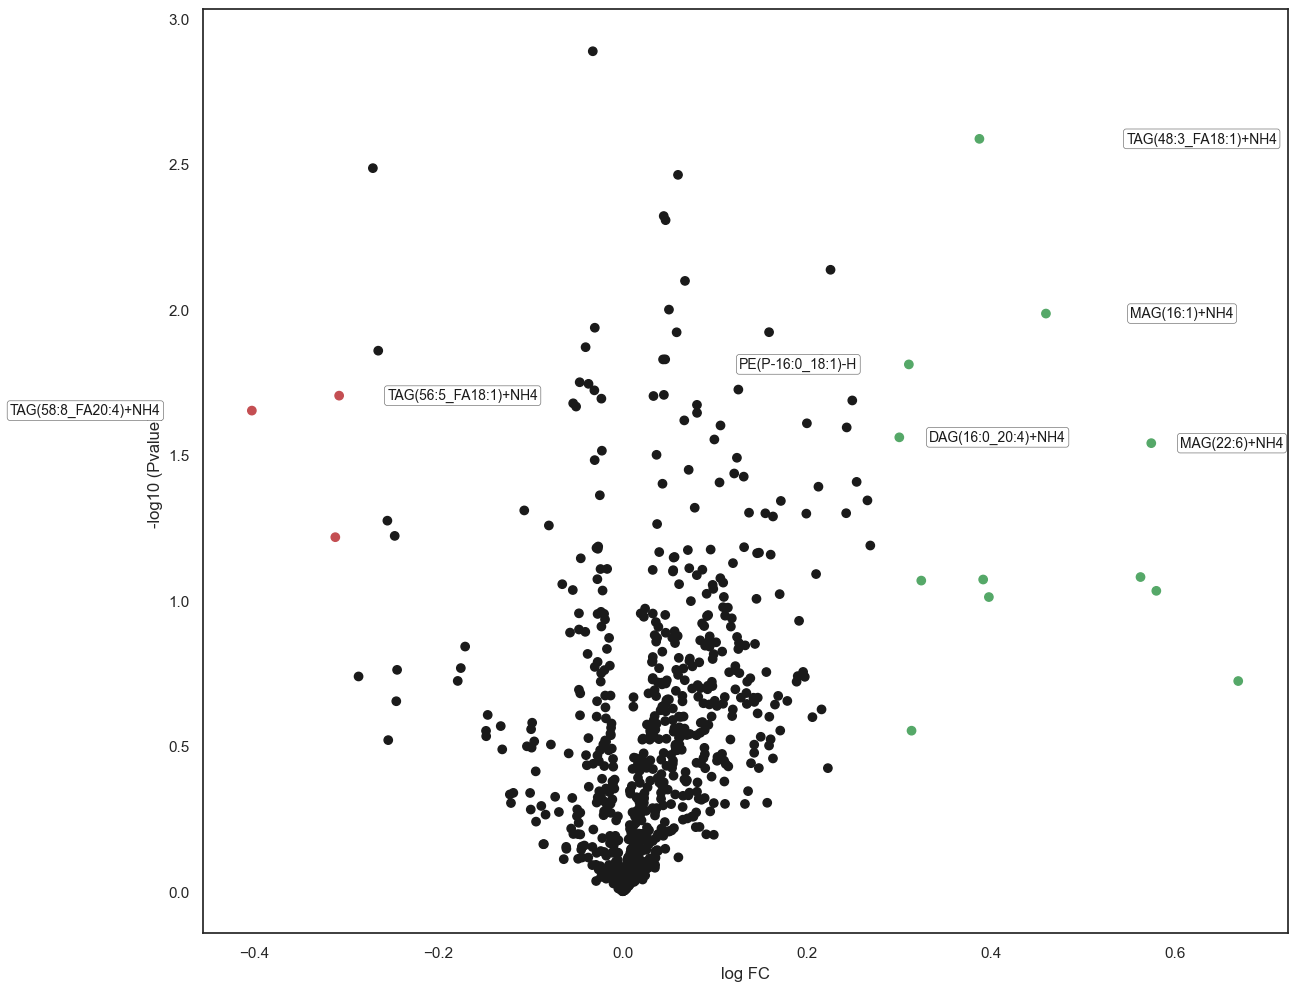

In [36]:
plot_volcano(results_all,fc_threshold=0.3, pvalue_threshold=1.5)

## Analysis striatum vs cortex

In [37]:
factor = 'TissueType'
results_all = []
for l in lipids_list:
    data_lipid = data[data['Individual Lipid Species'] == l]
    if data_lipid[factor].unique().size > 1: # Some lipids are not found in both classes
        for c in itertools.combinations(data_lipid[factor].unique(),2):
            a = data_lipid[data_lipid[factor] == c[0]]['logNormalizedArea'].values
            b = data_lipid[data_lipid[factor] == c[1]]['logNormalizedArea'].values
            pvalue = ttest_ind(a,b)[1]
            fc = np.mean(a)/np.mean(b)
            results_all.append([l, fc, pvalue, c[0], c[1]])

colnames = ['lipid', 'fc', 'p', factor+'1', factor+'2']
results_all = pd.DataFrame(data=results_all, columns= colnames)
results_all.head()

results_all.to_csv('tissue_treatment.csv')

C:\Users\smran\AppData\Local\Temp\ipykernel_18528\195133759.py:9: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  pvalue = ttest_ind(a,b)[1]
C:\Users\smran\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:1250: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\smran\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:1250: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


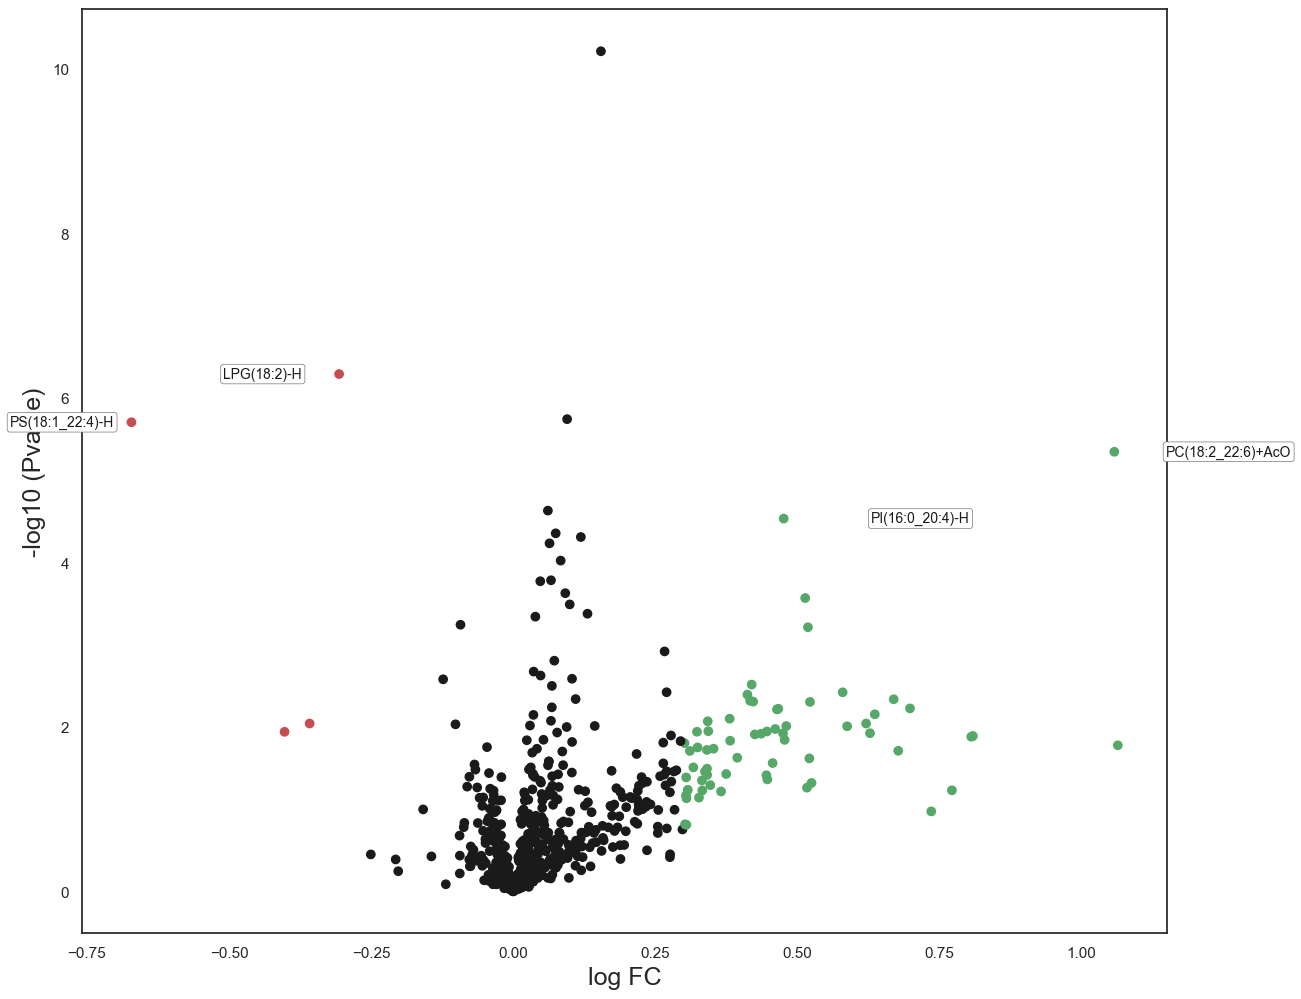

In [38]:
plot_volcano(results_all,fc_threshold=0.3, pvalue_threshold=4)

## Analysis 30 vs 60

In [39]:
factor = 'PND'
results_all = []
for l in lipids_list:
    data_lipid = data[data['Individual Lipid Species'] == l]
    if data_lipid[factor].unique().size > 1: # Some lipids are not found in both classes
        for c in itertools.combinations(data_lipid[factor].unique(),2):
            a = data_lipid[data_lipid[factor] == c[0]]['logNormalizedArea'].values
            b = data_lipid[data_lipid[factor] == c[1]]['logNormalizedArea'].values
            pvalue = ttest_ind(a,b)[1]
            fc = np.mean(a)/np.mean(b)
            results_all.append([l, fc, pvalue, c[0], c[1]])

colnames = ['lipid', 'fc', 'p', factor+'1', factor+'2']
results_all = pd.DataFrame(data=results_all, columns= colnames)
results_all.head()

results_all.to_csv('pnd_treatment.csv')

C:\Users\smran\AppData\Local\Temp\ipykernel_18528\3123342990.py:9: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  pvalue = ttest_ind(a,b)[1]
C:\Users\smran\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:1250: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\smran\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:1250: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


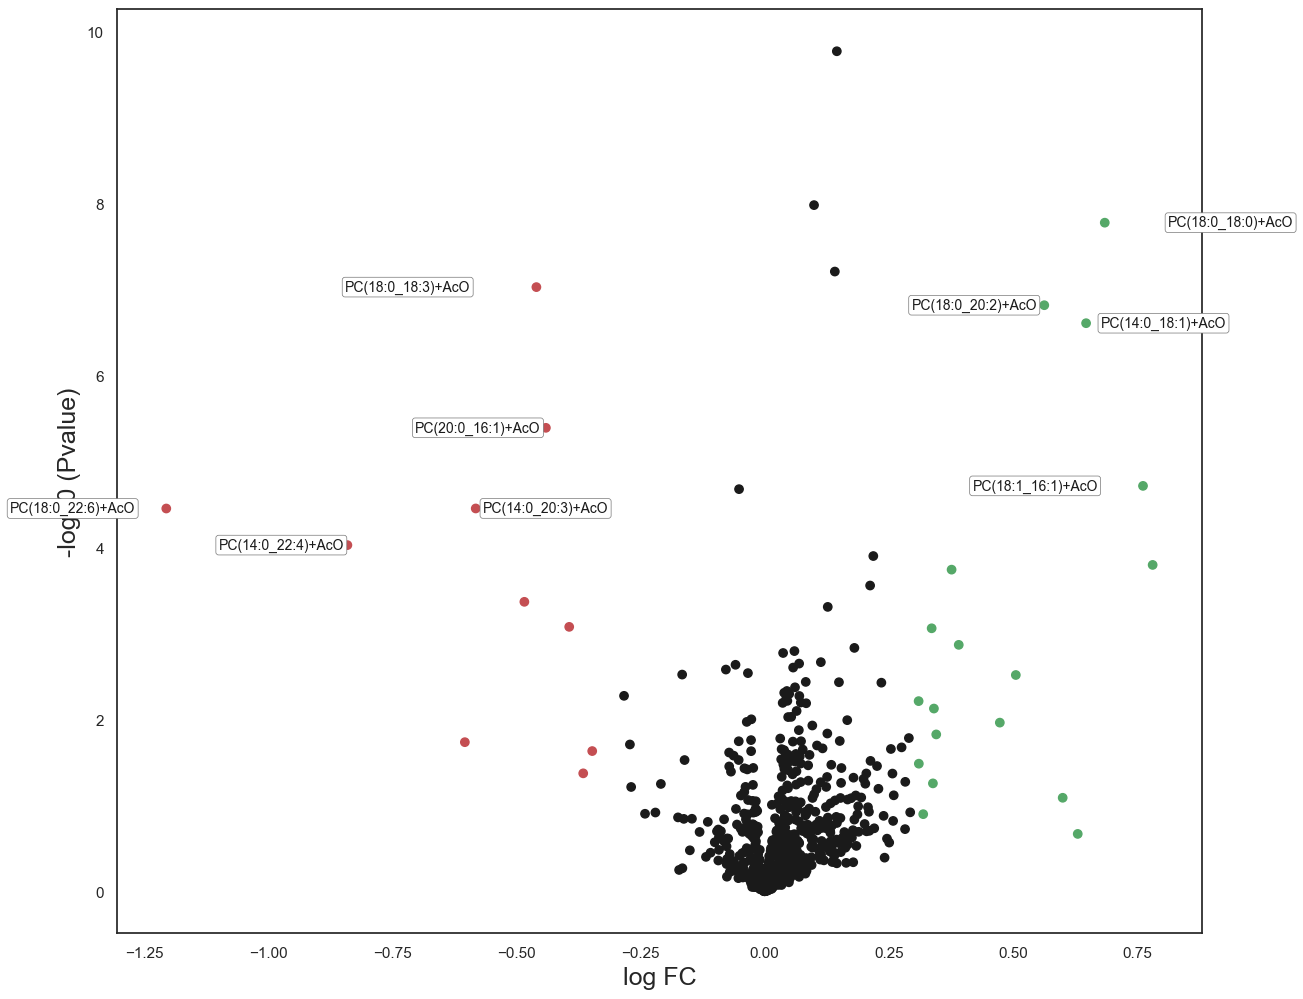

In [40]:
plot_volcano(results_all,fc_threshold=0.3, pvalue_threshold=4)

## Analysis male vs female

In [41]:
factor = 'Sex'
results_all = []
for l in lipids_list:
    data_lipid = data[data['Individual Lipid Species'] == l]
    if data_lipid[factor].unique().size > 1: # Some lipids are not found in both classes
        for c in itertools.combinations(data_lipid[factor].unique(),2):
            a = data_lipid[data_lipid[factor] == c[0]]['logNormalizedArea'].values
            b = data_lipid[data_lipid[factor] == c[1]]['logNormalizedArea'].values
            pvalue = ttest_ind(a,b)[1]
            fc = np.mean(a)/np.mean(b)
            results_all.append([l, fc, pvalue, c[0], c[1]])

colnames = ['lipid', 'fc', 'p', factor+'1', factor+'2']
results_all = pd.DataFrame(data=results_all, columns= colnames)
results_all.head()

results_all.to_csv('sex_treatment.csv')

C:\Users\smran\AppData\Local\Temp\ipykernel_18528\1807654400.py:9: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  pvalue = ttest_ind(a,b)[1]
C:\Users\smran\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:1250: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\smran\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:1250: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


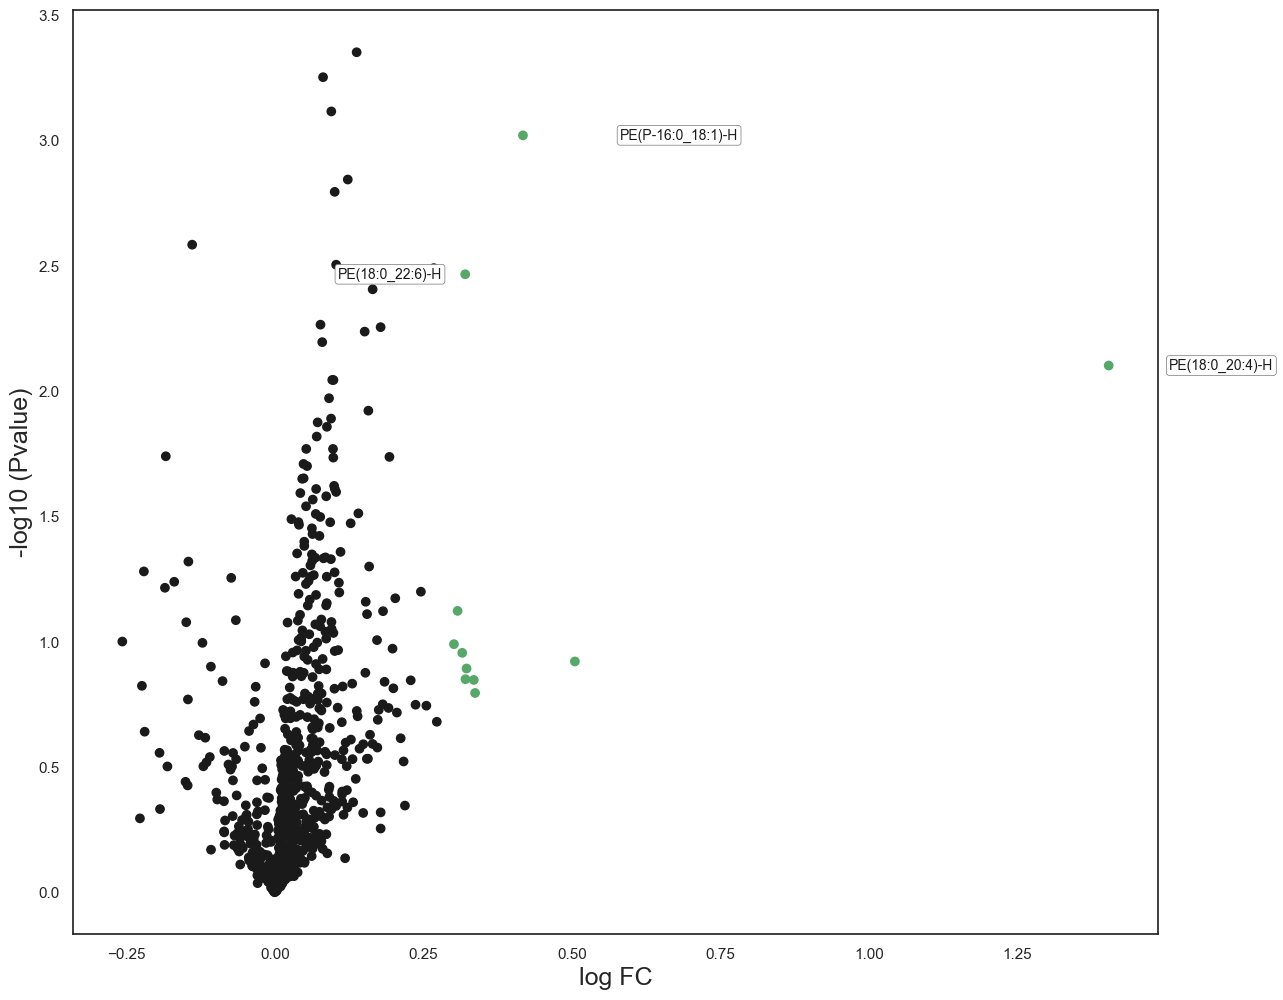

In [42]:
plot_volcano(results_all,fc_threshold=0.3, pvalue_threshold=2)